Purpose of this notebook is to check for the significance of parameters on the SEQ and WAL gas prices
The current parameters for consideration are 
- Demand/Supply (VIC,NSW,QLD,LNG [QLD]) - skipped for now
- Temperature in VIC 
- Temp in NSW 
- Prices (VIC/NSW)
- Prices (JKM - spot cargos, JCC - spas)

In [234]:
import pandas as pd 
import numpy as np 
import sklearn as sk 
import math 
import seaborn as sns 
import matplotlib.pyplot as plt
import datetime 

In [235]:
# pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)

Loading the relevant data 

In [236]:
## Allows us to calculate the VWAP at SEQ and WAL 

trades = pd.read_excel('Gas_Data/GSH Historical Trades.xlsx')
trades = trades.replace(to_replace = 'WAL Non-netted', value = 'WAL')

In [237]:
## Creates VWAP for SEQ and WAL in trades df

trades ['v*p'] = trades['DAILY_QTY_GJ'] * trades['TRADE_PRICE']
tester = trades.groupby(['TRADE_DATE', 'LOCATION'], as_index= False).sum()
tester['VWAP'] = tester['v*p']/tester['DAILY_QTY_GJ']
tester.drop( labels = ['TRADE_PRICE', 'DAILY_QTY_GJ', 'v*p'] , axis = 1, inplace=True)


WAL = tester[tester ['LOCATION'] == 'WAL'].copy()
WAL.rename(columns={ "LOCATION": "WAL", 'VWAP': "VWAP(WAL)"}, inplace= True )

SEQ = tester[tester ['LOCATION'] == 'SEQ'].copy()
SEQ.rename(columns={ "LOCATION": "SEQ", 'VWAP': "VWAP(SEQ)"}, inplace= True )

trades_df = WAL.merge(SEQ, on = 'TRADE_DATE', suffixes = (None, None), how = 'outer')


In [238]:
## Price data for SYD,ADL and BRISVEGAS markets
## Expost price is used

sttm_price = pd.read_excel("Gas_Data/STTM Price and Withdrawals.xlsx", sheet_name = 'Deviation Prices')
sttm_price = sttm_price[['DateTime','expost_imbalance_price','hub_name']]
sttm_price.tail()

,DateTime,expost_imbalance_price,hub_name
8851,2022-11-29,24.2321,BRI
8852,2022-11-29,21.8000,SYD
8853,2022-11-30,24.8000,ADL
8854,2022-11-30,24.0111,BRI
8855,2022-11-30,23.5711,SYD


In [239]:
## VIC Market demand and price data 
## Note that the expost price is used with the 6am price being the reference price 
## Skip demand/supply for now. 

dwgm_price = pd.read_excel("Gas_Data/DWGM Prices and Demand.xlsx", sheet_name='Prices')
dwgm_price.head()

# dwgm_demand = pd.read_excel("DWGM Prices and Demand.xlsx", sheet_name='Demand')
# dwgm_demand[dwgm_demand['Gas_Date'] == '2022-12-13']
# dwgm_demand.tail()

,Gas_Date,Hour,Price
0,2007-02-01,6,3.355
1,2007-02-01,10,3.380
2,2007-02-01,14,3.380
3,2007-02-01,18,3.355
4,2007-02-01,22,3.355


In [240]:
## Function to convert date into correct format for Temp dataframes 
def create_date(year, month, day):
    output = str(year) +"/"+ str(month) +"/"+ str(day)

    return output 

In [241]:
syd_mtemp = pd.read_csv('Weather_Data/syd(observatory_hill)_maxtemp.csv')
mel_mtemp = pd.read_csv('Weather_Data/melb(olympic_park)_maxtemp.csv')

syd_mtemp['Date'] = syd_mtemp.apply(lambda row: create_date(row['Year'], row['Month'], row['Day']), axis = 1)
syd_mtemp['Date']= pd.to_datetime(syd_mtemp['Date'])
syd_mtemp = syd_mtemp[['Date', 'Maximum temperature (Degree C)']]
syd_mtemp.rename(columns={'Maximum temperature (Degree C)': 'Syd_Temp'}, inplace= True)


mel_mtemp['Date'] = mel_mtemp.apply(lambda row: create_date(row['Year'], row['Month'], row['Day']), axis = 1)
mel_mtemp['Date']= pd.to_datetime(mel_mtemp['Date'])
mel_mtemp = mel_mtemp[['Date', 'Maximum temperature (Degree C)']]
mel_mtemp.rename(columns={'Maximum temperature (Degree C)': 'Mel_Temp'}, inplace= True)


gladstone_maxtemp = pd.read_csv('Weather_Data/gladstone_maxtemp1.csv') ## Gladstone Radar data 
gladstone_maxtemp['Date'] = gladstone_maxtemp.apply(lambda row: create_date(row['Year'], row['Month'], row['Day']), axis = 1)
gladstone_maxtemp['Date']= pd.to_datetime(gladstone_maxtemp['Date'])
gladstone_maxtemp = gladstone_maxtemp[['Date','Maximum temperature (Degree C)' ]]
gladstone_maxtemp.rename(columns={'Maximum temperature (Degree C)': 'Gladstone1_Temp'}, inplace= True)

gladstone_maxtemp2 = pd.read_csv('Weather_Data/gladstone_maxtemp2.csv')
gladstone_maxtemp2['Date'] = gladstone_maxtemp2.apply(lambda row: create_date(row['Year'], row['Month'], row['Day']), axis = 1)
gladstone_maxtemp2['Date']= pd.to_datetime(gladstone_maxtemp2['Date'])
gladstone_maxtemp2 = gladstone_maxtemp2[['Date','Maximum temperature (Degree C)' ]]
gladstone_maxtemp2.rename(columns={'Maximum temperature (Degree C)': 'Gladstone2_Temp'}, inplace= True)


# syd_mtemp.tail()
# mel_mtemp.tail()

In [242]:
gladstone_maxtemp[gladstone_maxtemp['Gladstone1_Temp'].isnull()]

gladstone_maxtemp2[gladstone_maxtemp2['Gladstone2_Temp'].isnull()]



,Date,Gladstone2_Temp
0,1993-01-01,NaN
1,1993-01-02,NaN
2,1993-01-03,NaN
3,1993-01-04,NaN
4,1993-01-05,NaN
...,...,...
9414,2018-10-11,NaN
10142,2020-10-08,NaN
10526,2021-10-27,NaN
10527,2021-10-28,NaN


In [243]:
gladstone_maxtemp.merge(gladstone_maxtemp2, on = 'Date')


,Date,Gladstone1_Temp,Gladstone2_Temp
0,1993-01-01,29.5,NaN
1,1993-01-02,29.8,NaN
2,1993-01-03,30.2,NaN
3,1993-01-04,30.4,NaN
4,1993-01-05,31.1,NaN
...,...,...,...
10934,2022-12-09,31.6,30.9
10935,2022-12-10,28.5,29.2
10936,2022-12-11,30.2,29.7
10937,2022-12-12,31.3,30.7


In [244]:
mel_mtemp.head()

,Date,Mel_Temp
0,2013-01-01,NaN
1,2013-01-02,NaN
2,2013-01-03,NaN
3,2013-01-04,NaN
4,2013-01-05,NaN


In [245]:
syd_mtemp.head()

,Date,Syd_Temp
0,2017-01-01,NaN
1,2017-01-02,NaN
2,2017-01-03,NaN
3,2017-01-04,NaN
4,2017-01-05,NaN


Adding in the JCC, JKM (ICE and Platt), and Dated Brent

In [246]:
markers = pd.read_excel('JKM_JCC(Oliver).xlsx',  sheet_name= 'Source Data_Historicals')
markers = markers.iloc[:,[0,2,3,9,10,12,13]] ## Recovers columns corresponding to ICE JKM, Platts JKM, JCC, and Dated Brent (and the respective datetime columns too)

markers.head()

,Unnamed: 0,ICE JKM,Platts JKM,Unnamed: 9,JCC,Unnamed: 12,Dated Brent
0,Series Function,ICEOTC.JKM,AAOVQ00,Series Function,PAJ.CRUDE.OIL.USD,Series Function,PCAAS00
1,NaN,Close,Index (USD/MMBTU),NaN,Close,NaN,Close (USD/BBL)
2,NaN,"ICE OTC, JKM, LNG Futures",Platts: LNG Japan/Korea DES Spot Crg (DW USD/MMB),NaN,"Petroleum Association of Japan, Oil Import Pri...",NaN,Platts: Dated Brent (DW USD/BBL)
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-12-05 00:00:00,32.158,36.243,2022-09-01 00:00:00,110.7882,2022-12-05 00:00:00,85.59


In [247]:
jkms = markers.iloc[:,[0,1,2]]
jcc =  markers.iloc[:,[3,4]]
dbrent =  markers.iloc[:,[5,6]]

dbrent = dbrent.drop(labels = [0,1,2,3], axis = 0)
jkms = jkms.drop(labels = [0,1,2,3], axis = 0)
jcc = jcc.drop(labels = [0,1,2,3], axis = 0)

In [248]:

dbrent.columns = ['Date', 'Dated_Brent']
dbrent['Date'] = pd.to_datetime(dbrent['Date'])
dbrent.head(10)

,Date,Dated_Brent
4,2022-12-05,85.59
5,2022-12-02,86.945
6,2022-12-01,89.08
7,2022-11-30,86.54
8,2022-11-29,83.94
9,2022-11-28,82.65
10,2022-11-25,85.475
11,2022-11-24,85.485
12,2022-11-23,85.315
13,2022-11-22,89.4


In [249]:
dbrent.dtypes

Date           datetime64[ns]
Dated_Brent            object
dtype: object

In [250]:
jcc.columns = ['Date', 'JCC']
jcc['Date'] = pd.to_datetime(jcc['Date'])
jcc.head()

,Date,JCC
4,2022-09-01,110.7882
5,2022-08-01,112.4639
6,2022-07-01,116.3807
7,2022-06-01,116.9194
8,2022-05-01,107.8182


In [251]:
dbrent

,Date,Dated_Brent
4,2022-12-05,85.59
5,2022-12-02,86.945
6,2022-12-01,89.08
7,2022-11-30,86.54
8,2022-11-29,83.94
...,...,...
3913,NaT,NaN
3914,NaT,NaN
3915,NaT,NaN
3916,NaT,NaN


In [252]:
## Creating a proxy for daily JCC by taking JCC/Mean(Brent) * Brent 
## The average applies at a monthly level

dbrent.head()
# month_dbrent = dbrent.groupby(pd.Grouper(key = 'Date' ,freq='M', axis = 0), as_index= True).mean()
month_dbrent = dbrent
month_dbrent['month_year'] = pd.to_datetime(month_dbrent['Date']).dt.to_period('M')
month_dbrent.head()
month_dbrent = month_dbrent.groupby('month_year').mean()

month_jcc = jcc
month_jcc['month_year'] = pd.to_datetime(month_jcc['Date']).dt.to_period('M')
month_jcc.head()

month_jccdbrent = month_dbrent.merge(month_jcc, on = 'month_year')
month_jccdbrent['JCC'] = month_jccdbrent['JCC'].astype('float64')
month_jccdbrent['JCC/Brent'] = month_jccdbrent['JCC']/month_jccdbrent['Dated_Brent']

# month_jccdbrent[month_jccdbrent['JCC/Brent'].notnull()]
month_jccdbrent.head(50)


# month_jccdbrent.dtypes



,month_year,Date_x,Dated_Brent,Date_y,JCC,JCC/Brent
0,2016-04,2016-04-12 00:00:00.000000000,42.930000,2016-04-01,36.9773,0.861339
1,2016-05,2016-05-31 00:00:00.000000000,49.250000,2016-05-01,40.7460,0.827330
2,2016-06,2016-06-01 00:00:00.000000000,48.145000,2016-06-01,45.2888,0.940675
3,2016-09,2016-09-14 00:00:00.000000000,45.935000,2016-09-01,45.5545,0.991717
4,2016-12,2016-12-17 04:14:07.058823424,53.736471,2016-12-01,46.7571,0.870119
5,2017-01,2017-01-16 14:51:25.714285824,54.670714,2017-01-01,53.4878,0.978363
6,2017-02,2017-02-14 07:12:00.000000000,55.112000,2017-02-01,55.3335,1.004019
7,2017-03,2017-03-16 08:20:52.173913088,51.564130,2017-03-01,56.1174,1.088303
8,2017-04,2017-04-15 12:00:00.000000000,52.534722,2017-04-01,53.8499,1.025034
9,2017-05,2017-05-15 17:08:34.285714176,50.426190,2017-05-01,53.9149,1.069184


In [253]:
jcc_proxy = dbrent.merge(month_jccdbrent, on = 'month_year')
jcc_proxy['JCC_Proxy'] = jcc_proxy['Dated_Brent_x'] * jcc_proxy['JCC/Brent']
jcc_proxy = jcc_proxy.drop(labels=['month_year', 'Date_x', 'Dated_Brent_y', 'Date_y','JCC/Brent', 'JCC'], axis = 1)
jcc_proxy.head(10)

,Date,Dated_Brent_x,JCC_Proxy
0,2022-09-30,87.92,108.387763
1,2022-09-29,89.805,110.71159
2,2022-09-28,88.27,108.819243
3,2022-09-27,86.39,106.501579
4,2022-09-26,84.625,104.325687
5,2022-09-23,85.285,105.139335
6,2022-09-22,89.175,109.934926
7,2022-09-21,88.12,108.634323
8,2022-09-20,89.295,110.082862
9,2022-09-16,91.02,112.209442


In [254]:
jcc.head()
jcc.sort_values('Date', ascending= True)

,Date,JCC,month_year
133,2011-12-01,114.1336,2011-12
132,2012-01-01,113.3657,2012-01
131,2012-02-01,116.3442,2012-02
130,2012-03-01,121.3647,2012-03
129,2012-04-01,126.9068,2012-04
...,...,...,...
3913,NaT,NaN,NaT
3914,NaT,NaN,NaT
3915,NaT,NaN,NaT
3916,NaT,NaN,NaT


In [255]:

jkms.columns = ['Date', 'ICE_JKM', 'Platt_JKM']
jkms['Date'] = pd.to_datetime(jkms['Date'])
jkms.head()

,Date,ICE_JKM,Platt_JKM
4,2022-12-05,32.158,36.243
5,2022-12-02,32.286,32.765
6,2022-12-01,31.417,38.075
7,2022-11-30,33.75,33.505
8,2022-11-29,31.331,31.149


Merging all the data to the same dataframe

In [256]:
df = jkms.merge(syd_mtemp, left_on = 'Date', right_on = 'Date')
df = df.merge(mel_mtemp, left_on = 'Date', right_on = 'Date')
df = df.merge(sttm_price[sttm_price['hub_name'] == 'SYD'], left_on= 'Date', right_on= 'DateTime')
df = df.merge(dwgm_price[dwgm_price['Hour'] == 6], left_on= 'Date', right_on= 'Gas_Date')
df = df.merge(trades_df[['TRADE_DATE', 'VWAP(WAL)', 'VWAP(SEQ)']], left_on='Date', right_on= 'TRADE_DATE')
df = df.merge(jcc_proxy, on = 'Date')


df = df.drop(columns=['DateTime', 'TRADE_DATE', 'hub_name', 'Gas_Date', 'Hour'])
df = df.rename(columns ={'expost_imbalance_price': 'Syd_Price', 'Price': 'Mel_Price'})

df
# pd.concat([jkms, syd_mtemp],join = 'inner')

,Date,ICE_JKM,Platt_JKM,Syd_Temp,Mel_Temp,Syd_Price,Mel_Price,VWAP(WAL),VWAP(SEQ),Dated_Brent_x,JCC_Proxy
0,2022-09-30,37.442,37.412,19.0,20.1,21.0088,20.1223,20.228571,NaN,87.92,108.387763
1,2022-09-29,37.599,38.037,20.1,15.6,20.5000,21.4444,20.558824,23.30,89.805,110.71159
2,2022-09-28,40.99,39.572,23.9,16.0,17.0200,19.9044,21.444643,23.30,88.27,108.819243
3,2022-09-27,38.584,39.052,22.8,15.9,18.0000,15.6200,19.956522,20.50,86.39,106.501579
4,2022-09-26,36.717,35.319,20.7,16.0,18.8011,14.9000,19.959167,19.25,84.625,104.325687
...,...,...,...,...,...,...,...,...,...,...,...
1332,2017-03-23,5.382,5.35,NaN,25.1,9.7382,7.5900,8.500000,NaN,49.925,54.333529
1333,2017-03-10,6.086,5.9,NaN,23.8,11.3900,10.4690,9.100000,NaN,50.675,55.149757
1334,2017-03-09,6.096,5.95,NaN,32.3,11.3900,10.5000,9.100000,NaN,50.76,55.242262
1335,2017-03-08,6.121,6.05,NaN,31.5,12.3000,10.5500,8.200000,NaN,53.795,58.545262


Correlation Heatmap (DATA THAT SHARES THE SAME DATE)
---


In [257]:
df['ICE_JKM'] = pd.to_numeric(df['ICE_JKM'])
df['Platt_JKM'] = pd.to_numeric(df['Platt_JKM'])
df['JCC_Proxy'] = pd.to_numeric(df['JCC_Proxy'])
df['Dated_Brent_x'] = pd.to_numeric(df['Dated_Brent_x'])




In [258]:
df.corr()

,ICE_JKM,Platt_JKM,Syd_Temp,Mel_Temp,Syd_Price,Mel_Price,VWAP(WAL),VWAP(SEQ),Dated_Brent_x,JCC_Proxy
ICE_JKM,1.000000,0.981702,-0.125801,-0.032997,0.577119,0.551628,0.648389,0.658824,0.738446,0.746275
Platt_JKM,0.981702,1.000000,-0.122116,-0.032114,0.561319,0.535795,0.630355,0.637864,0.737250,0.728956
Syd_Temp,-0.125801,-0.122116,1.000000,0.607950,-0.299639,-0.301316,-0.288091,-0.262352,-0.149344,-0.141375
Mel_Temp,-0.032997,-0.032114,0.607950,1.000000,-0.204834,-0.225919,-0.191778,-0.174561,-0.043985,-0.051147
Syd_Price,0.577119,0.561319,-0.299639,-0.204834,1.000000,0.968075,0.965594,0.957115,0.692476,0.717465
Mel_Price,0.551628,0.535795,-0.301316,-0.225919,0.968075,1.000000,0.947133,0.946641,0.690945,0.711495
VWAP(WAL),0.648389,0.630355,-0.288091,-0.191778,0.965594,0.947133,1.000000,0.979908,0.741858,0.774549
VWAP(SEQ),0.658824,0.637864,-0.262352,-0.174561,0.957115,0.946641,0.979908,1.000000,0.740098,0.758484
Dated_Brent_x,0.738446,0.737250,-0.149344,-0.043985,0.692476,0.690945,0.741858,0.740098,1.000000,0.904573
JCC_Proxy,0.746275,0.728956,-0.141375,-0.051147,0.717465,0.711495,0.774549,0.758484,0.904573,1.000000


<AxesSubplot:>

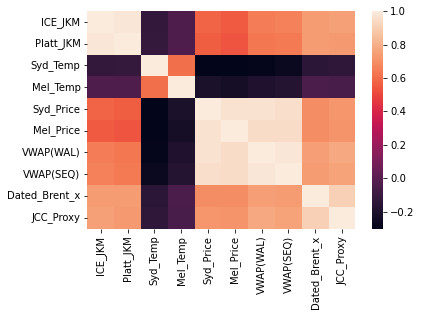

In [259]:
sns.heatmap(df.corr())

Now lets look at correlation with an offset between the VWAP prices and the remaining parameters
---

In [260]:
df[['Date','VWAP(WAL)', 'VWAP(SEQ)']]

,Date,VWAP(WAL),VWAP(SEQ)
0,2022-09-30,20.228571,NaN
1,2022-09-29,20.558824,23.30
2,2022-09-28,21.444643,23.30
3,2022-09-27,19.956522,20.50
4,2022-09-26,19.959167,19.25
...,...,...,...
1332,2017-03-23,8.500000,NaN
1333,2017-03-10,9.100000,NaN
1334,2017-03-09,9.100000,NaN
1335,2017-03-08,8.200000,NaN


In [261]:
df.iloc[:,[0,1,2,3,4,5,6,9,10]]

,Date,ICE_JKM,Platt_JKM,Syd_Temp,Mel_Temp,Syd_Price,Mel_Price,Dated_Brent_x,JCC_Proxy
0,2022-09-30,37.442,37.412,19.0,20.1,21.0088,20.1223,87.920,108.387763
1,2022-09-29,37.599,38.037,20.1,15.6,20.5000,21.4444,89.805,110.711590
2,2022-09-28,40.990,39.572,23.9,16.0,17.0200,19.9044,88.270,108.819243
3,2022-09-27,38.584,39.052,22.8,15.9,18.0000,15.6200,86.390,106.501579
4,2022-09-26,36.717,35.319,20.7,16.0,18.8011,14.9000,84.625,104.325687
...,...,...,...,...,...,...,...,...,...
1332,2017-03-23,5.382,5.350,NaN,25.1,9.7382,7.5900,49.925,54.333529
1333,2017-03-10,6.086,5.900,NaN,23.8,11.3900,10.4690,50.675,55.149757
1334,2017-03-09,6.096,5.950,NaN,32.3,11.3900,10.5000,50.760,55.242262
1335,2017-03-08,6.121,6.050,NaN,31.5,12.3000,10.5500,53.795,58.545262


In [262]:
df_lagged = df.copy()

for i in range(1,8):
    df_lagged[('Date' + str(i))] = df_lagged['Date'] - datetime.timedelta(days = i)

In [263]:
df_lagged

,Date,ICE_JKM,Platt_JKM,Syd_Temp,Mel_Temp,Syd_Price,Mel_Price,VWAP(WAL),VWAP(SEQ),Dated_Brent_x,JCC_Proxy,Date1,Date2,Date3,Date4,Date5,Date6,Date7
0,2022-09-30,37.442,37.412,19.0,20.1,21.0088,20.1223,20.228571,NaN,87.920,108.387763,2022-09-29,2022-09-28,2022-09-27,2022-09-26,2022-09-25,2022-09-24,2022-09-23
1,2022-09-29,37.599,38.037,20.1,15.6,20.5000,21.4444,20.558824,23.30,89.805,110.711590,2022-09-28,2022-09-27,2022-09-26,2022-09-25,2022-09-24,2022-09-23,2022-09-22
2,2022-09-28,40.990,39.572,23.9,16.0,17.0200,19.9044,21.444643,23.30,88.270,108.819243,2022-09-27,2022-09-26,2022-09-25,2022-09-24,2022-09-23,2022-09-22,2022-09-21
3,2022-09-27,38.584,39.052,22.8,15.9,18.0000,15.6200,19.956522,20.50,86.390,106.501579,2022-09-26,2022-09-25,2022-09-24,2022-09-23,2022-09-22,2022-09-21,2022-09-20
4,2022-09-26,36.717,35.319,20.7,16.0,18.8011,14.9000,19.959167,19.25,84.625,104.325687,2022-09-25,2022-09-24,2022-09-23,2022-09-22,2022-09-21,2022-09-20,2022-09-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,2017-03-23,5.382,5.350,NaN,25.1,9.7382,7.5900,8.500000,NaN,49.925,54.333529,2017-03-22,2017-03-21,2017-03-20,2017-03-19,2017-03-18,2017-03-17,2017-03-16
1333,2017-03-10,6.086,5.900,NaN,23.8,11.3900,10.4690,9.100000,NaN,50.675,55.149757,2017-03-09,2017-03-08,2017-03-07,2017-03-06,2017-03-05,2017-03-04,2017-03-03
1334,2017-03-09,6.096,5.950,NaN,32.3,11.3900,10.5000,9.100000,NaN,50.760,55.242262,2017-03-08,2017-03-07,2017-03-06,2017-03-05,2017-03-04,2017-03-03,2017-03-02
1335,2017-03-08,6.121,6.050,NaN,31.5,12.3000,10.5500,8.200000,NaN,53.795,58.545262,2017-03-07,2017-03-06,2017-03-05,2017-03-04,2017-03-03,2017-03-02,2017-03-01


            ICE_JKM  Platt_JKM  Syd_Temp  Mel_Temp  Syd_Price  Mel_Price  \
VWAP(SEQ)  0.661783   0.637810 -0.264512 -0.181686   0.952325   0.950879   
VWAP(WAL)  0.652521   0.628605 -0.280536 -0.197590   0.961725   0.947196   

           Dated_Brent_x  JCC_Proxy  
VWAP(SEQ)       0.738519   0.758033  
VWAP(WAL)       0.745190   0.779068  


<AxesSubplot:>

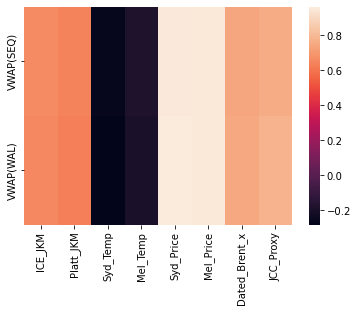

In [275]:
target_lagged1 = df_lagged[['VWAP(SEQ)', 'VWAP(WAL)', 'Date1']]
lag1 = target_lagged1.merge(df.drop(['VWAP(WAL)', 'VWAP(SEQ)'], axis = 1), how = 'inner', left_on= 'Date1', right_on= 'Date')
print(lag1.corr().iloc[0:2, 2:])

sns.heatmap(lag1.corr().iloc[0:2, 2:])
# sns.heatmap(lag1.corr())

           VWAP(SEQ)  VWAP(WAL)   ICE_JKM  Platt_JKM  Syd_Temp  Mel_Temp  \
VWAP(SEQ)   1.000000   0.980615  0.657010   0.617339 -0.268868 -0.159646   
VWAP(WAL)   0.980615   1.000000  0.653816   0.623878 -0.261946 -0.188698   

           Syd_Price  Mel_Price  Dated_Brent_x  JCC_Proxy  
VWAP(SEQ)   0.954098   0.947809       0.737624   0.753237  
VWAP(WAL)   0.959087   0.950480       0.748368   0.779096  


<AxesSubplot:>

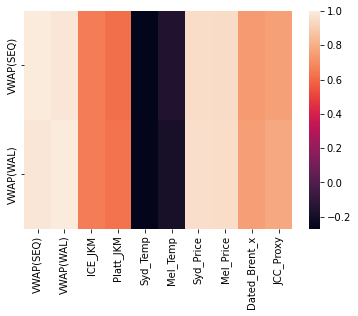

In [266]:
target_lagged2 = df_lagged[['VWAP(SEQ)', 'VWAP(WAL)', 'Date2']]
lag2 = target_lagged2.merge(df.drop(['VWAP(WAL)', 'VWAP(SEQ)'], axis = 1), how = 'inner', left_on= 'Date2', right_on= 'Date')
print(lag2.corr().iloc[0:2, 2:])
sns.heatmap(lag2.corr().iloc[0:2, 2:])

           VWAP(SEQ)  VWAP(WAL)   ICE_JKM  Platt_JKM  Syd_Temp  Mel_Temp  \
VWAP(SEQ)   1.000000   0.973825  0.661355   0.623117 -0.262448  -0.16303   
VWAP(WAL)   0.973825   1.000000  0.659442   0.636952 -0.266799  -0.18449   

           Syd_Price  Mel_Price  Dated_Brent_x  JCC_Proxy  
VWAP(SEQ)   0.948585   0.946752       0.748468   0.763010  
VWAP(WAL)   0.954457   0.952024       0.751469   0.780432  


<AxesSubplot:>

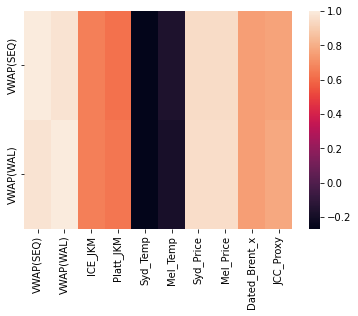

In [267]:
target_lagged3 = df_lagged[['VWAP(SEQ)', 'VWAP(WAL)', 'Date3']]
lag3 = target_lagged3.merge(df.drop(['VWAP(WAL)', 'VWAP(SEQ)'], axis = 1), how = 'inner', left_on= 'Date3', right_on= 'Date')
print(lag3.corr().iloc[0:2, 2:])
sns.heatmap(lag3.corr().iloc[0:2, 2:])

           VWAP(SEQ)  VWAP(WAL)   ICE_JKM  Platt_JKM  Syd_Temp  Mel_Temp  \
VWAP(SEQ)   1.000000   0.973483  0.661475   0.630837 -0.243078 -0.147974   
VWAP(WAL)   0.973483   1.000000  0.656683   0.636240 -0.287881 -0.187371   

           Syd_Price  Mel_Price  Dated_Brent_x  JCC_Proxy  
VWAP(SEQ)   0.936502   0.922464       0.751908   0.757766  
VWAP(WAL)   0.950352   0.930764       0.751725   0.780389  


<AxesSubplot:>

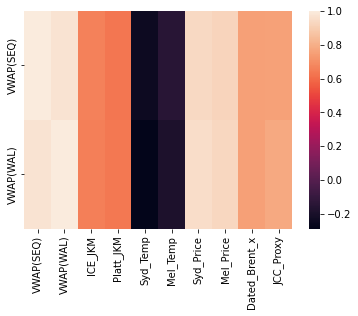

In [268]:
target_lagged4 = df_lagged[['VWAP(SEQ)', 'VWAP(WAL)', 'Date4']]
lag4 = target_lagged4.merge(df.drop(['VWAP(WAL)', 'VWAP(SEQ)'], axis = 1), how = 'inner', left_on= 'Date4', right_on= 'Date')
print(lag4.corr().iloc[0:2, 2:])
sns.heatmap(lag4.corr().iloc[0:2, 2:])

           VWAP(SEQ)  VWAP(WAL)   ICE_JKM  Platt_JKM  Syd_Temp  Mel_Temp  \
VWAP(SEQ)   1.000000   0.981843  0.652683   0.629775 -0.255461 -0.155983   
VWAP(WAL)   0.981843   1.000000  0.640435   0.630419 -0.290227 -0.192779   

           Syd_Price  Mel_Price  Dated_Brent_x  JCC_Proxy  
VWAP(SEQ)   0.930513   0.906905       0.744282   0.757073  
VWAP(WAL)   0.942050   0.940979       0.752857   0.774818  


<AxesSubplot:>

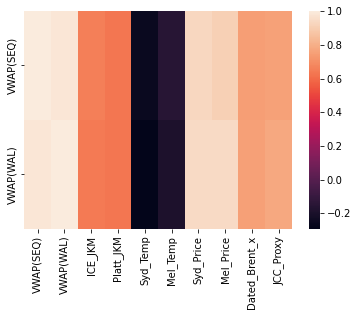

In [269]:
target_lagged5 = df_lagged[['VWAP(SEQ)', 'VWAP(WAL)', 'Date5']]
lag5 = target_lagged5.merge(df.drop(['VWAP(WAL)', 'VWAP(SEQ)'], axis = 1), how = 'inner', left_on= 'Date5', right_on= 'Date')
print(lag5.corr().iloc[0:2, 2:])
sns.heatmap(lag5.corr().iloc[0:2, 2:])

           VWAP(SEQ)  VWAP(WAL)   ICE_JKM  Platt_JKM  Syd_Temp  Mel_Temp  \
VWAP(SEQ)   1.000000   0.982975  0.649584   0.636393 -0.262217 -0.160502   
VWAP(WAL)   0.982975   1.000000  0.633940   0.625033 -0.269005 -0.186847   

           Syd_Price  Mel_Price  Dated_Brent_x  JCC_Proxy  
VWAP(SEQ)   0.932225   0.919740       0.740764   0.755594  
VWAP(WAL)   0.938505   0.932375       0.753996   0.772843  


<AxesSubplot:>

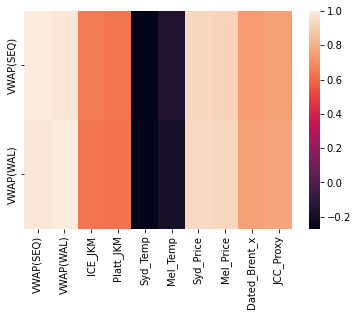

In [270]:
target_lagged6 = df_lagged[['VWAP(SEQ)', 'VWAP(WAL)', 'Date6']]
lag6 = target_lagged6.merge(df.drop(['VWAP(WAL)', 'VWAP(SEQ)'], axis = 1), how = 'inner', left_on= 'Date6', right_on= 'Date')
print(lag6.corr().iloc[0:2, 2:])
sns.heatmap(lag6.corr().iloc[0:2, 2:])

            ICE_JKM  Platt_JKM  Syd_Temp  Mel_Temp  Syd_Price  Mel_Price  \
VWAP(SEQ)  0.652449   0.627292 -0.265142 -0.163880   0.925925   0.923209   
VWAP(WAL)  0.637135   0.621920 -0.280680 -0.187148   0.931048   0.929555   

           Dated_Brent_x  JCC_Proxy  
VWAP(SEQ)       0.745324   0.755324  
VWAP(WAL)       0.757244   0.774230  


<AxesSubplot:>

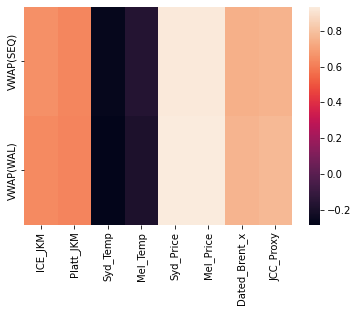

In [274]:
target_lagged7 = df_lagged[['VWAP(SEQ)', 'VWAP(WAL)', 'Date7']]
lag7 = target_lagged7.merge(df.drop(['VWAP(WAL)', 'VWAP(SEQ)'], axis = 1), how = 'inner', left_on= 'Date7', right_on= 'Date')
print(lag7.corr().iloc[0:2, 2:])
sns.heatmap(lag7.corr().iloc[0:2, 2:])

In [278]:
lagged_dfs = [lag1, lag2, lag3, lag4, lag5, lag6, lag7]

counter = 1
for i in lagged_dfs:
    print("Days before: ", counter)
    print(i.corr().iloc[0:2, 2:])
    counter +=1 


Days before:  1
            ICE_JKM  Platt_JKM  Syd_Temp  Mel_Temp  Syd_Price  Mel_Price  \
VWAP(SEQ)  0.661783   0.637810 -0.264512 -0.181686   0.952325   0.950879   
VWAP(WAL)  0.652521   0.628605 -0.280536 -0.197590   0.961725   0.947196   

           Dated_Brent_x  JCC_Proxy  
VWAP(SEQ)       0.738519   0.758033  
VWAP(WAL)       0.745190   0.779068  
Days before:  2
            ICE_JKM  Platt_JKM  Syd_Temp  Mel_Temp  Syd_Price  Mel_Price  \
VWAP(SEQ)  0.657010   0.617339 -0.268868 -0.159646   0.954098   0.947809   
VWAP(WAL)  0.653816   0.623878 -0.261946 -0.188698   0.959087   0.950480   

           Dated_Brent_x  JCC_Proxy  
VWAP(SEQ)       0.737624   0.753237  
VWAP(WAL)       0.748368   0.779096  
Days before:  3
            ICE_JKM  Platt_JKM  Syd_Temp  Mel_Temp  Syd_Price  Mel_Price  \
VWAP(SEQ)  0.661355   0.623117 -0.262448  -0.16303   0.948585   0.946752   
VWAP(WAL)  0.659442   0.636952 -0.266799  -0.18449   0.954457   0.952024   

           Dated_Brent_x  JCC_Proxy  

In [119]:
df['Date'] - datetime.timedelta(days = 1)

0      2022-09-29
1      2022-09-28
2      2022-09-27
3      2022-09-26
4      2022-09-25
          ...    
1332   2017-03-22
1333   2017-03-09
1334   2017-03-08
1335   2017-03-07
1336   2017-02-28
Name: Date, Length: 1337, dtype: datetime64[ns]

Gonna now run a couple regression models based on lagged data to see if we can predict prices
- Linear Reg
- Penalised Lin Reg (L1, L2) (Ridge etc.)
- SVM Regression 
- NN (Don't think this will really work)
- Decision Tree Regression 

